In [7]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import matplotlib.colors as colors
fname='/Users/mgrecu/WDomains/MCS_OK/wrfout_d03_2018-06-25_07:00:00'
with nc.Dataset(fname) as fh:
    qrain=fh.variables['QRAIN'][:,:,:]
    ncrain=fh.variables['QNRAIN'][:,:,:]
    qice=fh.variables['QICE'][:,:,:]
    ncice=fh.variables['QNICE'][:,:,:]
    qir=fh.variables['QIR'][:,:,:]
    xlon=fh.variables['XLONG'][0,:,:]
    xlat=fh.variables['XLAT'][0,:,:]
    height=fh.variables['PHB'][:,:,:,:]+fh.variables['PH'][0,:,:,:]
    sfc_height=fh.variables['HGT'][0,:,:]
    theta=fh.variables['T'][:,:,:,:]+300.
    p=fh.variables['P'][:,:,:,:]+fh.variables['PB'][:,:,:,:]
    t=theta*(p/100000.)**0.286
    rho=p/(287.*t)
print(qrain.shape)
print(rho[0,:,0,0])

(4, 83, 189, 201)
[1.034574270248413 1.028613567352295 1.0214282274246216 1.0124098062515259
 1.0012625455856323 0.9860411286354065 0.9655855894088745
 0.9446625113487244 0.9223489165306091 0.8989433646202087
 0.8757520914077759 0.8532533049583435 0.8312304019927979
 0.8099667429924011 0.7896766662597656 0.7698059678077698
 0.7499431371688843 0.7308362722396851 0.7131869196891785
 0.6952197551727295 0.675320565700531 0.6543700695037842
 0.6353734135627747 0.6185334920883179 0.6026801466941833
 0.5873960852622986 0.5723897814750671 0.5573850274085999
 0.5422742366790771 0.5273226499557495 0.5128663778305054
 0.49897632002830505 0.48556533455848694 0.47250640392303467
 0.4597371816635132 0.44711822271347046 0.43481555581092834
 0.4226977527141571 0.4108741879463196 0.39938628673553467
 0.38814306259155273 0.3770192563533783 0.3659382462501526
 0.35494789481163025 0.34404653310775757 0.33324572443962097
 0.32271668314933777 0.3127017915248871 0.3031405806541443
 0.2938643991947174 0.28481

(0.007429789, 0.008707808)
[[1.         0.71677343]
 [0.71677343 1.        ]]


(array([  4.,   0.,   0.,   2.,   7.,   5.,  11.,   9.,   5.,  11.,   9.,
         10.,  10.,  12.,   9.,  12.,  22.,  23.,  21.,  18.,  24.,  22.,
         22.,  29.,  30.,  43.,  39.,  44.,  45.,  57.,  71.,  66.,  89.,
        101., 110., 109., 110., 103., 111., 108., 127., 152., 156., 143.,
        183., 195., 264., 255., 301., 340., 404., 435., 451., 492., 446.,
        418., 399., 376., 444., 402., 391., 373., 335., 315., 303., 262.,
        236., 182., 183., 158., 139., 107.,  97.,  83.,  78.,  79.,  71.,
         79.,  66.,  55.,  48.,  57.,  62.,  62.,  46.,  40.,  46.,  45.,
         36.,  35.,  44.,  51.,  37.,  27.,  49.,  43.,  50.,  48.,  43.,
         20.]),
 array([0.4211596 , 0.42694801, 0.4327364 , 0.43852481, 0.4443132 ,
        0.45010161, 0.45589003, 0.46167842, 0.46746683, 0.47325522,
        0.47904363, 0.48483205, 0.49062043, 0.49640885, 0.50219727,
        0.50798565, 0.51377404, 0.51956248, 0.52535087, 0.53113925,
        0.5369277 , 0.54271609, 0.54850447, 0.

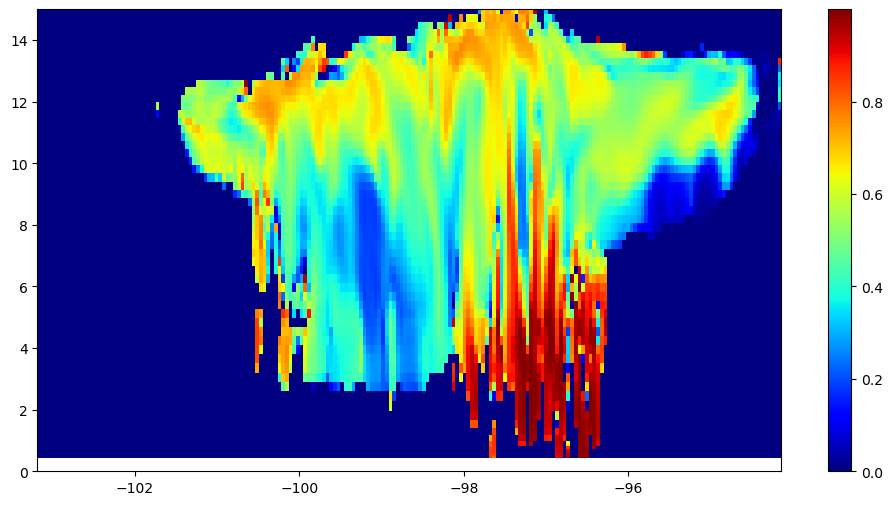

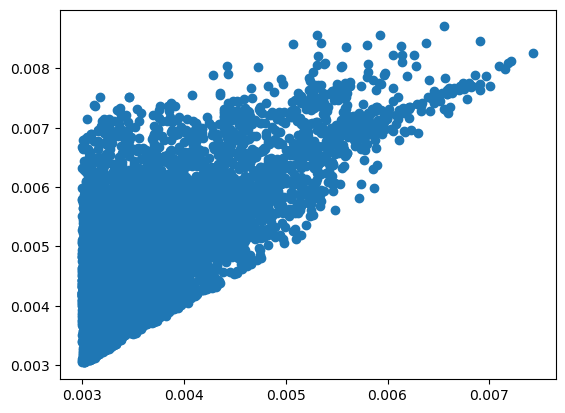

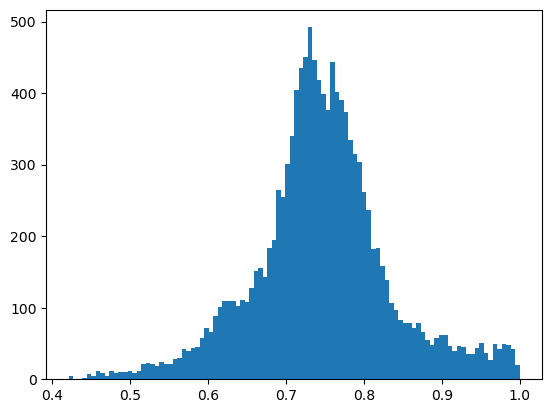

In [82]:
ny_sect=130
plt.figure(figsize=(12,6))
plt.pcolormesh(xlon[ny_sect,:],height[0,:-1,ny_sect,100]/9.81e3,((qir/(qice+1e-9))[0,:,ny_sect,:]),cmap='jet',)#,norm=colors.LogNorm(vmin=1e-6,vmax=6e-3),cmap='jet')
plt.colorbar()
print((qir.max(),qice.max()))
plt.ylim([0,15])
a=np.nonzero(qir>0.003)
plt.figure()
plt.scatter(qir[a],qice[a])
print(np.corrcoef(qir[a],qice[a]))
plt.figure()
plt.hist(qir[a]/qice[a],bins=100)


In [8]:
import lkTables
import numpy as np
lkTables=lkTables.scattTables() 
from bisectm import bisectm
it=0
a=np.nonzero(qrain[it,0,:,:]>1e-3)
rhoice=100.0
nz=qrain.shape[1]
nz80=80
qice_1d=np.zeros((nz80),float)
dmice_1d=np.zeros((nz80),float)
qrain_1d=np.zeros((nz80),float)
ncice_1d=np.zeros((nz80),float)

for i,j in zip(a[0],a[1]):
    qice_1dtmp=qice[it,:,i,j].copy()
    qrain_1dtmp=qrain[it,:,i,j].copy()
    dmice_1dtmp=qice[it,:,i,j].copy()*0
    dmrain_1dtmp=qrain[it,:,i,j].copy()*0
    hm=(height[it,1:,i,j]+height[it,:-1,i,j])/2/9.81e3
    hgrid=height[it,:,i,j]/9.81e3+np.arange(nz80)*0.25
    for k1 in range(nz-1,-1,-1):
        attKu=0
        attKa=0
        zku=0
        if(qice[it,k1,i,j]>1e-5):
            dmice=4/(ncice[it,k1,i,j]*3.1415*rhoice/qice[it,k1,i,j])**0.333*1e3
            dmice_1dtmp[k1]=dmice
        if(qrain[it,k1,i,j]>1e-5):
            dmrain=4/(ncrain[it,k1,i,j]*3.1415*1000/qrain[it,k1,i,j])**0.333*1e3
            dmrain_1dtmp[k1]=dmrain
        qrain_1d=np.interp(,height[it,:,i,j],qrain[it,:,i,j])
    break

0.4610426943352447 2.0558156e-05 43916.773
0.5412588328497681 0.00019542025 257878.45
0.5818618319767545 0.00041260815 438171.72
0.5667920681436435 0.0007163046 823051.1
0.5829851583028232 0.0025801582 2724190.5
0.6124407483033153 0.0052444693 4775388.0
0.6448954005126465 0.0061675706 4809260.5
0.6800865118243109 0.006052263 4023352.0
0.7157481235421694 0.005939168 3386421.5
0.7513154589816613 0.005905701 2910967.0
0.8049079001265286 0.005747439 2303449.8
0.9172998029548413 0.0054781316 1482760.6
1.158403099868139 0.005221544 701274.3
1.6197151635855966 0.0050915666 249900.11
1.7968864826042892 0.0055996375 201230.39
1.9667898169849012 0.005901611 161686.77
1.7367814264158294 0.0062386305 248309.72
1.8003862343892159 0.006130893 219038.12
1.8087886766385788 0.006101753 214970.12
1.8942484250761962 0.005920958 181596.69
2.0634609947432248 0.0057217907 135724.53
2.304130093198422 0.0056172744 95670.04
2.456967227879018 0.0056468816 79304.555
2.493484165728715 0.0056218267 75531.12
2.5172

In [ ]:


def simZKu(gwc,swc,rwc,dmg,dms,dmr,dr):
    n1=gwc.shape[0]
    piaKu=0
    piaKa=0
    zKuSim=np.zeros((n1),float)-99
    zKu_true=np.zeros((n1),float)-99
    zKaSim=np.zeros((n1),float)-99
    zKa_true=np.zeros((n1),float)-99
    kexttot=np.zeros((n1),float)
    salbtot=np.zeros((n1),float)
    asymtot=np.zeros((n1),float)
    
    nfreqm=8
    kext1D=np.zeros((n1,nfreqm),float)
    salb1D=np.zeros((n1,nfreqm),float)
    asym1D=np.zeros((n1,nfreqm),float)
    for k1 in range(n1-1,-1,-1):
        attKu=0
        attKa=0
        zku=0
        zka=0
        dns=0
        dng=0
        if k1<40:
            dns=-(40-max(k1,22))*0.075
        if k1<80 and k1>0:
            dng=-(24-k1)*0.075
        dng=max(-0.97,dng)
        dng=min(0.97,dng)
        #dns=0
        #dng=0
        dms[k1]=max(lkTables.dms[0],dms[k1])
        dms[k1]=min(dms[k1],lkTables.dms[-1])
        dmg[k1]=max(lkTables.dmg[0],dmg[k1])
        dmg[k1]=min(dmg[k1],lkTables.dmg[-1])
        dmr[k1]=max(lkTables.dmr[0],dmr[k1])
        dmr[k1]=min(dmr[k1],lkTables.dmr[-1])
        if gwc[k1]>0:
            #ind=bisectm(lkTables.gwc.data,272,gwc[k1]/10**dng)
            ind=bisectm(lkTables.dmg.data,272,dmg[k1])
            dng=np.log10(gwc[k1]/lkTables.gwc.data[ind])
            zKug=lkTables.zKuG[ind]+10*dng
            zKag=lkTables.zKaG[ind]+10*dng
            attKug=lkTables.attKuG[ind]*10**dng
            attKag=lkTables.attKaG[ind]*10**dng
            attKu+=attKug
            attKa+=attKag
            zku+=10**(0.1*zKug)
            zka+=10**(0.1*zKag)
            kext1D[k1,:]+=lkTables.kextG[ind,:]*10**dng
            salb1D[k1,:]+=lkTables.kextG[ind,:]*10**dng*lkTables.salbG[ind,:]
            asym1D[k1,:]+=lkTables.kextG[ind,:]*10**dng*lkTables.salbG[ind,:]*lkTables.asymG[ind,:]
        if swc[k1]>0:
            ind=bisectm(lkTables.dms.data,253,dms[k1])
            dns=np.log10(swc[k1]/lkTables.swc.data[ind])
            zKus=lkTables.zKuS[ind]+10*dns
            zKas=lkTables.zKaS[ind]+10*dns
            attKus=lkTables.attKuS[ind]*10**dns
            attKas=lkTables.attKaS[ind]*10**dns
            attKu+=attKus
            attKa+=attKas
            zku+=10**(0.1*zKus)
            zka+=10**(0.1*zKas)
            kext1D[k1,:]+=lkTables.kextS[ind,:]*10**dns
            salb1D[k1,:]+=lkTables.kextS[ind,:]*10**dns*lkTables.salbS[ind,:]
            asym1D[k1,:]+=lkTables.kextS[ind,:]*10**dns*lkTables.salbS[ind,:]*lkTables.asymS[ind,:]
        if rwc[k1]>0:
            ind=bisectm(lkTables.dmr.data,289,dmr[k1])
            dnr=np.log10(rwc[k1]/lkTables.rwc.data[ind])
            #ind=bisectm(lkTables.rwc.data,289,rwc[k1])
            zKur=lkTables.zKuR[ind]+10*dnr
            zKar=lkTables.zKaR[ind]+10*dnr
            attKur=lkTables.attKuR[ind]*10**dnr
            attKar=lkTables.attKaR[ind]*10**dnr
            attKu+=attKur
            attKa+=attKar
            zku+=10**(0.1*zKur)
            zka+=10**(0.1*zKar)
            kext1D[k1,:]+=lkTables.kextR[ind,:]*10**dnr
            salb1D[k1,:]+=lkTables.kextR[ind,:]*10**dnr*lkTables.salbR[ind,:]
            asym1D[k1,:]+=lkTables.kextR[ind,:]*10**dnr*lkTables.salbR[ind,:]*lkTables.asymR[ind,:]
        if attKu>0:
            piaKu+=attKu*dr
            piaKa+=attKa*dr
            zKuSim[k1]=10*np.log10(zku)-piaKu
            zKaSim[k1]=10*np.log10(zka)-piaKa
            zKu_true[k1]=10*np.log10(zku)
            zKa_true[k1]=10*np.log10(zka)
            piaKu+=attKu*dr
            piaKa+=attKa*dr
    kexttot[:]=kext1D[:,3]+1e-4
    salbtot[:]=salb1D[:,3]#/kexttot[:]
    asymtot[:]=asym1D[:,3]/(salb1D[:,3]+1e-4)      
    n1=80
    noms=0
    alt=400
    freqKa=35.5
    nonorm=1
    theta=0.5
    #print(kexttot[0:n1].sum()*dr*4.343*2,piaKa)
    #print(salbtot.max(),salbtot.min())
    #print(asymtot.max(),asymtot.min())
    #stop
    zms = libSc.multiscatterf(kexttot[0:n1][::-1],salbtot[0:n1][::-1],asymtot[0:n1][::-1],\
                            zKa_true[0:n1][::-1],dr,noms,alt,theta,freqKa,nonorm)
    
    return zKuSim,zKu_true,piaKu,zKaSim,zKa_true,piaKa,zms[::-1]


(189, 201)


/var/folders/x_/d2_jzyq50052xh1_tk02bnmc0000gq/T/ipykernel_78533/2774462772.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(xlon[ny1:,:nx1],xlat[ny1:,:nx1],qrain[0,0,ny1:,:nx1],cmap='jet',norm=colors.LogNorm(vmin=1e-5))
/var/folders/x_/d2_jzyq50052xh1_tk02bnmc0000gq/T/ipykernel_78533/2774462772.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(xlon[ny1:,:nx1],xlat[ny1:,:nx1],qrain[-1,0,ny1:,:nx1],cmap='jet',norm=colors.LogNorm(vmin=1e-5))


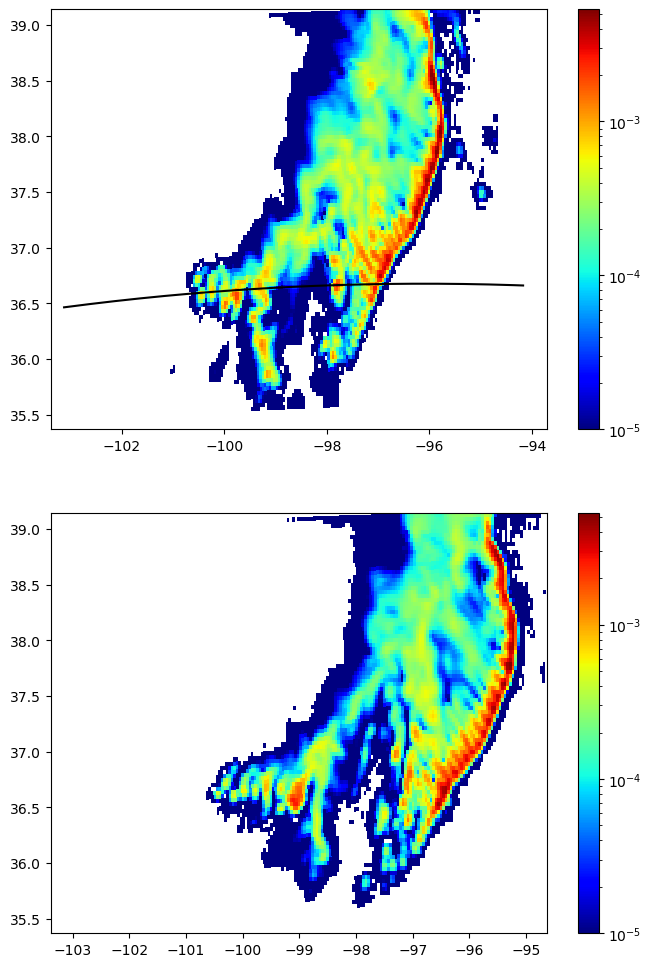

In [61]:
plt.figure(figsize=(8,12))
plt.subplot(211)
nx1=189
ny1=90
print(xlon.shape)
plt.pcolormesh(xlon[ny1:,:nx1],xlat[ny1:,:nx1],qrain[0,0,ny1:,:nx1],cmap='jet',norm=colors.LogNorm(vmin=1e-5))
plt.plot(xlon[120,:],xlat[120,:],'k')
plt.colorbar()
plt.subplot(212)
plt.pcolormesh(xlon[ny1:,:nx1],xlat[ny1:,:nx1],qrain[-1,0,ny1:,:nx1],cmap='jet',norm=colors.LogNorm(vmin=1e-5))
plt.colorbar()